In [17]:
# necessary libraries
import numpy as np
import pandas as pd
import re
import seaborn as sns
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import random
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.util import ngrams

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# algorithms implemented
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB 
import numpy as np
from sklearn.feature_selection import chi2

### Development an end-to-end machine learning process for text classification

### Loading data

In [18]:
data = pd.read_csv(
    rf"C:\Users\krisi.afezolli\Desktop\personal_project\visable_coding_challenge\sample_data_for_task1.csv")

data

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft
...,...,...
37290,spirituosen dienstleister,ft
37291,mini hydraulikzylinder,ct
37292,blockbodenbeutel verpackungen,pkg
37293,Drehteile verpacken,mr


### Text exploration

In [19]:
data.tail(10)

,text,label
37285,wasserstoff druckregelventile,ch
37286,big bag entleeranlagen,pkg
37287,w 400 538 40 8000,ft
37288,gas compressors,ch
37289,Werkzeugschleifereien Heckerstieg,mr
37290,spirituosen dienstleister,ft
37291,mini hydraulikzylinder,ct
37292,blockbodenbeutel verpackungen,pkg
37293,Drehteile verpacken,mr
37294,bagger tanks,ct


In [20]:
agg = data.groupby('label').agg({'label': 'count'})
agg

,label
label,
ch,3688
cnc,2587
ct,5061
ft,11226
mr,5016
pkg,9617


We have six unique leabels throughout the dataset and as we goupby we see that label: `ft` is ranking with 11,226 occurrences. 

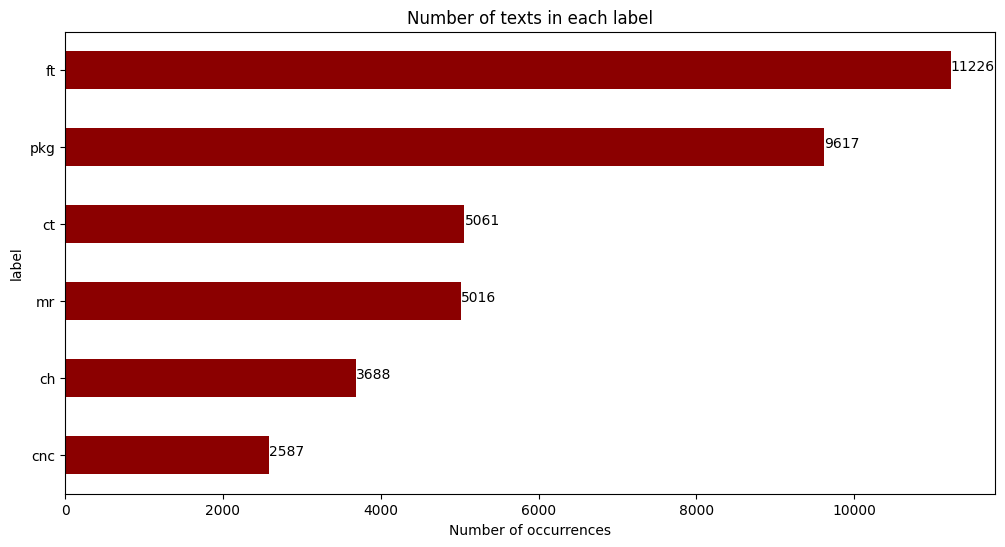

In [21]:
fig = plt.figure(figsize=(12, 6))
data_grouped = data.groupby('label')['text'].count().sort_values()
data_grouped.plot.barh(
    ylim=0, title='Number of texts in each label', color='darkred')
plt.xlabel('Number of occurrences', fontsize=10)

# Adding labels on the bars
for index, value in enumerate(data_grouped):
    plt.text(value, index, str(value))

plt.show()

In [22]:
data.isna().sum()

text       0
label    100
dtype: int64

In [23]:
data = data.dropna()
data.isna().sum()

text     0
label    0
dtype: int64

In [24]:
data.shape

(37195, 2)

In [25]:
data['text'][:20]

0                             zucker fabrik
1              Lebensmittel kommssionierung
2                           geländer biegen
3              gebäudeausrüstung technische
4                     kürbiskernöl softgels
5             Lebensmittel Organic Getränke
6                   plastikflaschen abfälle
7                          Knoblauch frisch
8                Lohnarbeiten für Druckguss
9                          etiketten metall
10                    sonderformteile blech
11          wasserstrahlschneiden Aluminium
12                          ladenbau bäcker
13                           industrie gase
14                 walter Metall cnc Bohrer
15                  individuelle verpackung
16                               0402544096
17          konfektionierung faltschachteln
18    Stahlbau (DIN EN 1090-3 Niedersachsen
19                          anodieren titan
Name: text, dtype: object

In [26]:
numeric_rows = data[data['text'].apply(lambda x: x.isnumeric())]
numeric_rows

,text,label
16,0402544096,cnc
138,04025440183,ct
247,04025440215,ch
514,04025440195,ct
529,04025440104,ft
...,...,...
36949,04025440222,cnc
37079,0402544013,pkg
37084,0402544014,ft
37227,040254406,cnc


In [27]:
data = data[~data['text'].str.isnumeric()]
data[:20]

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft
5,Lebensmittel Organic Getränke,ft
6,plastikflaschen abfälle,pkg
7,Knoblauch frisch,ft
8,Lohnarbeiten für Druckguss,ct
9,etiketten metall,pkg


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36895 entries, 0 to 37294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    36895 non-null  object
 1   label   36895 non-null  object
dtypes: object(2)
memory usage: 864.7+ KB


A stop word is a commonly used word (such as in our case in German “kann”, “jetz”, “keine”, “keines”etc) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

In [29]:
nltk.download('stopwords')
text_column = data['text']
german_stopwords = set(stopwords.words('german'))
german_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krisi.afezolli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'aber',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'als',
 'also',
 'am',
 'an',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer',
 'anderes',
 'anderm',
 'andern',
 'anderr',
 'anders',
 'auch',
 'auf',
 'aus',
 'bei',
 'bin',
 'bis',
 'bist',
 'da',
 'damit',
 'dann',
 'das',
 'dass',
 'dasselbe',
 'dazu',
 'daß',
 'dein',
 'deine',
 'deinem',
 'deinen',
 'deiner',
 'deines',
 'dem',
 'demselben',
 'den',
 'denn',
 'denselben',
 'der',
 'derer',
 'derselbe',
 'derselben',
 'des',
 'desselben',
 'dessen',
 'dich',
 'die',
 'dies',
 'diese',
 'dieselbe',
 'dieselben',
 'diesem',
 'diesen',
 'dieser',
 'dieses',
 'dir',
 'doch',
 'dort',
 'du',
 'durch',
 'ein',
 'eine',
 'einem',
 'einen',
 'einer',
 'eines',
 'einig',
 'einige',
 'einigem',
 'einigen',
 'einiger',
 'einiges',
 'einmal',
 'er',
 'es',
 'etwas',
 'euch',
 'euer',
 'eure',
 'eurem',
 'euren',
 'eurer',
 'eures',
 'für',
 'gegen',
 'gewesen',
 'hab',
 'habe',
 'haben',
 'hat',
 'hatte',
 'hatten',
 'hier',


In [30]:
# checking if text column has punctuations
def check_punctuation(text):
    for row in text:
        for char in row:
            if char in string.punctuation:
                return True
    return False

In [31]:
check_punctuation(data['text'])

True

In [32]:
mask = data['text'].apply(check_punctuation)
rows_with_punctuation = data[mask]
rows_with_punctuation.head()

,text,label
18,Stahlbau (DIN EN 1090-3 Niedersachsen,ct
50,- DIE norm vertriebs VON NORM- und sonderteile...,ft
87,"Beratung, baubiologische ink",ct
115,Tiefziehen hauch*,mr
116,balkonmöbel (Dienstleistung),ct


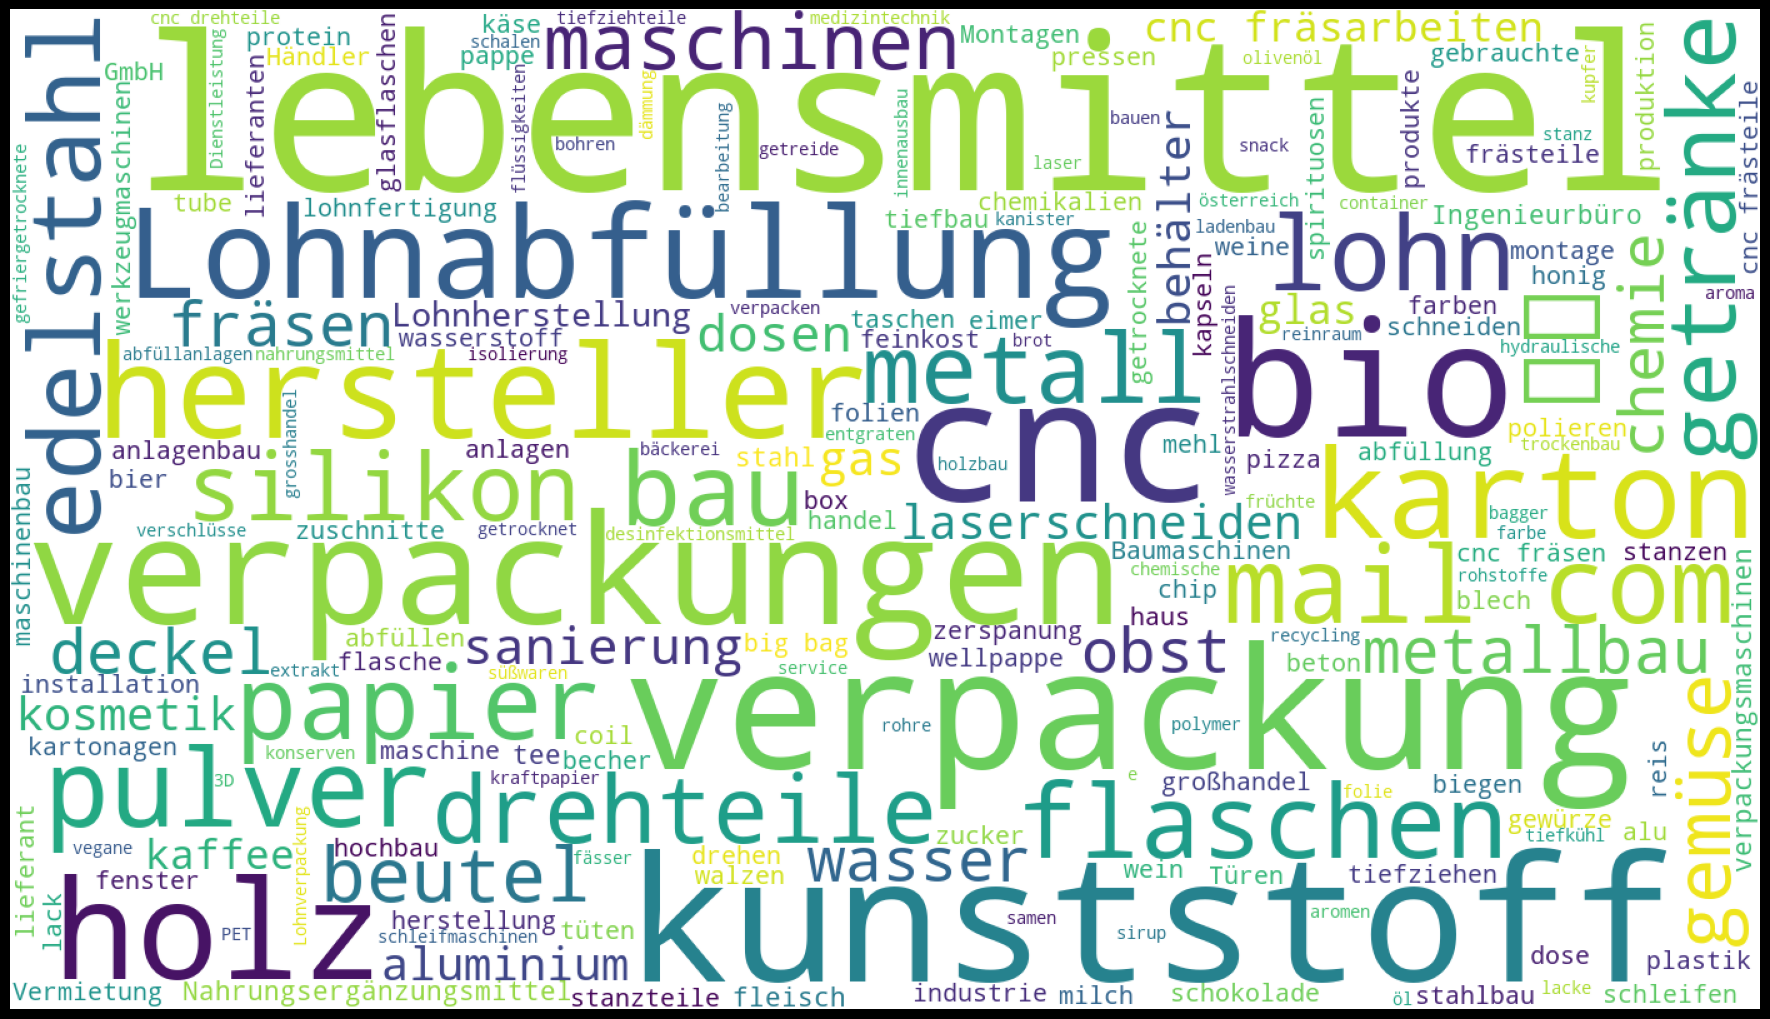

In [33]:
def generate_wordcloud(text, stopwords, ngram=1):
    # Flatten the list if it's a list of lists
    flat_text = [word for sentence in text for word in sentence] if isinstance(
        text[0], list) else text

    # text: when ngram > 1, text should be a dictionary
    if ngram == 1:
        wordcloud = WordCloud(width=1400, height=800, background_color='white',
                              stopwords=stopwords).generate(' '.join(flat_text))
    else:
        wordcloud = WordCloud(width=1400, height=800, background_color='white',
                              stopwords=stopwords).generate_from_frequencies(text)

    plt.figure(figsize=(20, 10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


generate_wordcloud(data['text'], set(stopwords.words('german')))

### Text preprocessing

The TF-IDF (Term Frequency-Inverse Document Frequency) vectorization process includes both tokenization and the exclusion of german stop words as we saw above.

In [34]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words=list(stopwords.words('german')))

# We transform each `text` into a vector
features = tfidf.fit_transform(data['text']).toarray()
labels = data['label']
print("Each of the %d texts is represented by %d features (TF-IDF score of unigrams and bigrams)" % (features.shape))

Each of the 36895 texts is represented by 2874 features (TF-IDF score of unigrams and bigrams)


In [35]:
N = 3
max_rows = 5

# Calculate chi-squared scores for the entire dataset
features_chi2 = chi2(features, labels)

for label in sorted(set(labels)):
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print(f"For label '{label}':")
    print("  * Most Correlated Unigrams are: %s" % (', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" % (', '.join(bigrams[-N:])))

    row_count = 0
    # Iterate over each text and check if it belongs to the current label
    for text, text_label in data[['text', 'label']].itertuples(index=False):
        if text_label == label:
            print(f"    - {text}")
            row_count += 1
            if row_count == max_rows:
                break
    print("\n")

For label 'ch':
  * Most Correlated Unigrams are: gas, silikon, cnc
  * Most Correlated Bigrams are: cnc frästeile, cnc fräsen, cnc fräsarbeiten
    - industrie gase
    - silikon streifen
    - ammonium hydrogen carbonat
    - Aminosäuren leucin
    - motoren für rollenbahnen


For label 'cnc':
  * Most Correlated Unigrams are: gas, silikon, cnc
  * Most Correlated Bigrams are: cnc frästeile, cnc fräsen, cnc fräsarbeiten
    - walter Metall cnc Bohrer
    - titan werkzeugbau
    - 5 achsen cnc fräsmaschinen
    - cnc frästeile aus carbon
    - vertikaldrehmaschinen und


For label 'ct':
  * Most Correlated Unigrams are: gas, silikon, cnc
  * Most Correlated Bigrams are: cnc frästeile, cnc fräsen, cnc fräsarbeiten
    - gebäudeausrüstung technische
    - Lohnarbeiten für Druckguss
    - Stahlbau (DIN EN 1090-3 Niedersachsen
    - bau endreinigungen
    - reinraum isolator


For label 'ft':
  * Most Correlated Unigrams are: gas, silikon, cnc
  * Most Correlated Bigrams are: cnc frästeil

### Multiclassification models

We will split the data into train and test sets. We will use 75% of the data for training and the rest for testing. Column text_tokens_no_stopwords will be our X or the input, and the label is our Y or the output/target.

In [36]:
X = data['text']  # features
y = data['label']  # labels we want to predict

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27671,), (9224,), (27671,), (9224,))

We will keep all the models in a list and loop through the list for each model to get a mean accuracy and standard deviation to calculate and compare the performance for each of these models. Then, we can decide with which model we can move further.

In [38]:
# Define a list with all the models we want to test to find out which one scores better
models = [LogisticRegression(random_state=42),
          RandomForestClassifier(
              n_estimators=100, max_depth=5, random_state=42),
          LinearSVC(),
          MultinomialNB()]

# Adding Cross Validation check
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
results = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(
        model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        results.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(
    results, columns=['model_name', 'cv_iteration', 'accuracy'])
cv_df

C:\Users\krisi.afezolli\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\krisi.afezolli\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

,model_name,cv_iteration,accuracy
0,LogisticRegression,0,0.839951
1,LogisticRegression,1,0.856349
2,LogisticRegression,2,0.861634
3,LogisticRegression,3,0.856349
4,LogisticRegression,4,0.859602
5,RandomForestClassifier,0,0.377964
6,RandomForestClassifier,1,0.381759
7,RandomForestClassifier,2,0.385960
8,RandomForestClassifier,3,0.382843
9,RandomForestClassifier,4,0.389077


In [39]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.856403,0.008378
LogisticRegression,0.854777,0.008588
MultinomialNB,0.844505,0.007236
RandomForestClassifier,0.383521,0.004221


### Evaluating multiclassification model

As seen above LinearSVC is the best performer

Now, let's train our model using ‘Linear Support Vector Machine’, so that we can evaluate and check its performance on unseen data.

In [40]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, data.index, test_size=0.25, random_state=42)

model = LinearSVC()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\krisi.afezolli\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


This is a classification report to get more insights into model performance.

In [41]:
print('Classification metrics:')
print(metrics.classification_report(
    y_test, y_pred, target_names=data['label'].unique()))

Classification metrics:
              precision    recall  f1-score   support

          ft       0.93      0.81      0.87       901
          mr       0.87      0.72      0.78       640
          ct       0.94      0.86      0.90      1250
         pkg       0.81      0.93      0.86      2854
          ch       0.80      0.82      0.81      1195
         cnc       0.89      0.85      0.87      2384

    accuracy                           0.86      9224
   macro avg       0.87      0.83      0.85      9224
weighted avg       0.86      0.86      0.86      9224



- From the above classification report, we can observe that the classes that have a greater number of occurrences tend to have a good f1-score compared to other classes. 
- The categories which yield better classification results are `cnc`, `ft` and `ct`. 


### Prediction on the unseen/fresh data

Let's try some use cases to check our predictions:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words=list('german'))

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

C:\Users\krisi.afezolli\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [43]:
text_tokens_no_stopwords = "Tiefziehen, hauch"
print(model.predict(fitted_vectorizer.transform([text_tokens_no_stopwords])))

['mr']


In [44]:
text_tokens_no_stopwords = "gebäudeausrüstung, technische"
print(model.predict(fitted_vectorizer.transform([text_tokens_no_stopwords])))

['ct']


In [45]:
text_tokens_no_stopwords = "geländer, biegen"
print(model.predict(fitted_vectorizer.transform([text_tokens_no_stopwords])))

['mr']


In [46]:
text_tokens_no_stopwords = "blockbodenbeutel, verpackungen"
print(model.predict(fitted_vectorizer.transform([text_tokens_no_stopwords])))

['pkg']


In [47]:
text_tokens_no_stopwords = "spirituosen"
print(model.predict(fitted_vectorizer.transform([text_tokens_no_stopwords])))

['ft']


In [48]:
data

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft
...,...,...
37290,spirituosen dienstleister,ft
37291,mini hydraulikzylinder,ct
37292,blockbodenbeutel verpackungen,pkg
37293,Drehteile verpacken,mr


In [49]:
# saving the model to a specific path
joblib.dump(model, rf'C:\Users\krisi.afezolli\Desktop\personal_project\visable_coding_challenge\linear_svc_model.joblib')

['C:\\Users\\krisi.afezolli\\Desktop\\personal_project\\visable_coding_challenge\\linear_svc_model.joblib']